In [1]:
import pickle

with open('../../PNC_Good/MegaMeta3.pkl', 'rb') as f: 
    meta = pickle.load(f)
    
print('Complete')

Complete


In [2]:
with open('../../Work/LatentSim/Splits.pkl', 'rb') as f:
    keys, groups = pickle.load(f)
    
print(len(keys))
print(len(groups[0][0])+len(groups[0][1]))
print('Complete')

620
620
Complete


In [3]:
import numpy as np

nback = np.stack([meta[key]['nback'] for key in keys])
emoid = np.stack([meta[key]['emoid'] for key in keys])

print(nback.shape)
print(emoid.shape)

(620, 264, 231)
(620, 264, 210)


In [4]:
from nilearn.connectome import ConnectivityMeasure

def getFC(timeSeries, kind='correlation', transpose=True):
    connMeasure = ConnectivityMeasure(kind=kind)
    if transpose:
        timeSeries = np.transpose(timeSeries, axes=(0,2,1))
    return connMeasure.fit_transform(timeSeries)

nback_p = getFC(nback)
emoid_p = getFC(emoid)

print(nback_p.shape)

(620, 264, 264)


In [7]:
import torch

def convertTorch(p):
    t = torch.from_numpy(p).float()
    u = []
    for i in range(t.shape[0]):
        u.append(t[i][torch.triu_indices(264,264,offset=1).unbind()])
    return torch.stack(u).cuda()

nback_p_t = convertTorch(nback_p)
emoid_p_t = convertTorch(emoid_p)

print(nback_p_t.shape)
print(emoid_p_t.shape)
print('Complete')

torch.Size([620, 34716])
torch.Size([620, 34716])
Complete


In [5]:
age = np.stack([meta[key]['AgeInMonths'] for key in keys])
gen = np.stack([np.array([meta[key]['Gender'] == 'M', meta[key]['Gender'] == 'F']) for key in keys]).astype(int)
wrt = np.stack([meta[key]['wratStd'] for key in keys])

print(age.shape)
print(gen.shape)
print(wrt.shape)

(620,)
(620, 2)
(620,)


In [8]:
age_t = torch.from_numpy(age).float().cuda()
gen_t = torch.from_numpy(gen).float().cuda()
wrt_t = torch.from_numpy(wrt).float().cuda()

print('Complete')

Complete


In [79]:
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn.dense import DenseGCNConv
import time

def arith(n):
    return int(n*(n+1)/2)

class GCN(nn.Module):
    def __init__(self, nTgt, dp=0.5):
        super(GCN, self).__init__()
        self.gcn = []
        for i in range(2*nTgt):
            self.gcn.append(DenseGCNConv(arith(263),20).float().cuda())
            self.gcn.append(DenseGCNConv(20,1).float().cuda())
        self.gcn = nn.ModuleList(self.gcn)
        self.dp = nn.Dropout(p=dp)

    def forward(self, x):
        e = torch.ones(x.shape[0], x.shape[0]).float().cuda()/x.shape[0]
        x = self.dp(x)
        res = []
        for i in range(x.shape[1]):
            y = F.relu(self.gcn[2*i](x[:,i,:],e)).squeeze()
            y = self.gcn[2*i+1](y,e).squeeze()
            res.append(y)
        return res
    
def mask(e):
    return e - torch.diag(torch.diag(e.detach()))

class LatSim(nn.Module):
    def __init__(self, nTgts, dp=0.5, edp=0.1):
        super(LatSim, self).__init__()
        self.active = nn.Parameter(1e-4*torch.randn(nTgts,arith(263),2).float().cuda())
        self.dp = nn.Dropout(p=dp)
        self.edp = nn.Dropout(p=edp)
    
    def getLatentsAndEdges(self, x, i):
        e = 1e-10
        y = torch.einsum('ac,ce->ae', x, self.active[i])
        e = e+y@y.T
        return y, y, e
        
    def forward(self, x, y, testIdcs=None):
        res = []
        es = []
        x = self.dp(x)
        for i in range(self.active.shape[0]):
            _, _, e = self.getLatentsAndEdges(x[:,i,:], i)
            if testIdcs is not None:
                e[:,testIdcs] = 0
            e = self.edp(e)
            e = mask(e)
            e[e == 0] = float('-inf')
            e = F.softmax(e, dim=1)
            es.append(e)
            res.append(e@y)
        return res, es
    
class MLP(nn.Module):
    def __init__(self, dp=0.5):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(arith(263),1).float().cuda()
        self.dp = nn.Dropout(p=dp)

    def forward(self, x):
        x = self.dp(x)
        return self.fc1(x).squeeze()
    
def validate(model, X, y, testIdcs):
    model.eval()
    with torch.no_grad():
        res = model(X)
        avg = torch.mean(torch.stack(res), dim=0)
        if res[0].dim() == 1:
            loss = mseLoss(avg[testIdcs], y[testIdcs]).cpu().numpy()**0.5
        else:
            corr = (torch.argmax(avg, dim=1) == torch.argmax(y, dim=1))[testIdcs]
            loss = torch.sum(corr)/len(testIdcs)
    model.train()
    return loss

rmse = []

ceLoss = torch.nn.CrossEntropyLoss()
mseLoss = torch.nn.MSELoss()
nEpochs = 20000
pPeriod = 500
thresh = 300
    
for i in range(9,10):
    para = [nback_p_t, emoid_p_t]
    X = torch.stack(para, dim=1)

    mlp = GCN(2)
    params = list(mlp.parameters())
    optim = torch.optim.Adam(params, lr=1e-4, weight_decay=1e-4) # 2e-4

    trainIdcs = groups[i][0][0:496]
    validIdcs = groups[i][0]
    testIdcs = groups[i][1]

    Xt = X[trainIdcs]
    Xv = X[validIdcs]

    trainLoss = []
    validLoss = []

    val = age_t

    for epoch in range(nEpochs):
        Xt.grad = None
        optim.zero_grad()
        res = mlp(Xt)
        avg = torch.mean(torch.stack(res), dim=0)
        loss0 = 0
        for r in res + [avg]:
            loss0 += mseLoss(r, val[trainIdcs])/(len(res)+1)
        loss0 += 0.1*torch.sum(torch.abs(mlp.gcn[0].lin.weight))
        loss0 += 0.1*torch.sum(torch.abs(mlp.gcn[2].lin.weight))
        loss = torch.stack([loss0])
        torch.sum(loss).backward()
        optim.step()
        if epoch % pPeriod == 0 or epoch == nEpochs-1 or torch.all(loss[0:3] < thresh):
            print(f'epoch {epoch} loss={(float(loss0))}')
            lossV = validate(mlp, Xv, val[validIdcs], np.arange(496,len(validIdcs)))
            if len(validLoss) == 0 or lossV < min(validLoss):
                print(f'New best validation epoch {epoch} loss={lossV}')
                torch.save(mlp.state_dict(), '../../Work/LatentSim/mlp.pyt')
#                     finalRes[i] = Xt.grad.detach()
            validLoss.append(lossV)
            if torch.all(loss[0:3] < thresh):
                print('Early stopping')
                break

    print('Finished training')

    mlp.load_state_dict(torch.load('../../Work/LatentSim/mlp.pyt'))
    loss0 = validate(mlp, X, val, testIdcs)

    rmse.append((float(loss0)))
    print(rmse[-1])

#     topRMSE[i,j] = float(loss0)
#     print(f'{j} {i} {topRMSE[i,j]}')

epoch 0 loss=35587.0
New best validation epoch 0 loss=169.78977966308594
epoch 500 loss=2513.998291015625
New best validation epoch 500 loss=50.191253662109375
epoch 1000 loss=2189.16162109375
New best validation epoch 1000 loss=46.25108337402344
epoch 1500 loss=1978.6832275390625
New best validation epoch 1500 loss=42.71354675292969
epoch 2000 loss=1812.616455078125
New best validation epoch 2000 loss=39.771236419677734
epoch 2500 loss=1698.569580078125
New best validation epoch 2500 loss=37.687191009521484
epoch 3000 loss=1606.14208984375
New best validation epoch 3000 loss=36.233551025390625
epoch 3500 loss=1528.9862060546875
New best validation epoch 3500 loss=35.241756439208984
epoch 4000 loss=1466.40673828125
New best validation epoch 4000 loss=34.206661224365234
epoch 4500 loss=1404.2623291015625
New best validation epoch 4500 loss=33.35132598876953
epoch 5000 loss=1356.685546875
New best validation epoch 5000 loss=32.842559814453125
epoch 5500 loss=1316.208984375
New best valid

In [80]:
for err in rmse:
    print(err)
print('---')
print(sum(rmse)/len(rmse)/12)

28.993207931518555
---
2.4161006609598794


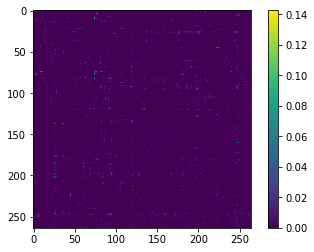

In [81]:
import matplotlib.pyplot as plt

def heatmap(cuda):
    iu = np.triu_indices(264, 1)
    m = np.zeros([264,264])
    v = cuda.detach().cpu().numpy()
    m[iu] = v
    m = m + m.T
    return m

plt.imshow(heatmap(torch.mean(mlp.gcn[0].lin.weight.detach()**2, dim=0)))
plt.colorbar()
plt.show()

In [83]:
torch.sum(mlp.gcn[0].lin.weight[0].detach()**2 > 0)

tensor(34716, device='cuda:0')

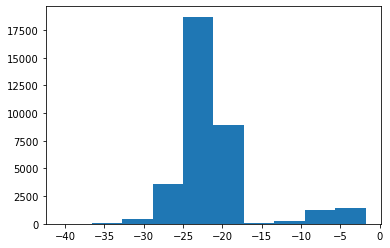

In [82]:
plt.hist(torch.log(mlp.gcn[0].lin.weight[0].detach()**2).cpu().numpy())
plt.show()

In [84]:
lst = torch.argsort(torch.mean(mlp.gcn[0].lin.weight.detach()**2, dim=0))[-10:].cpu().numpy()

In [85]:
a = np.triu_indices(264,1)[0][lst]
b = np.triu_indices(264,1)[1][lst]

print(np.stack([a,b]))

[[ 26  95  77  74  36  26  26 128   4  10]
 [246 197 181  77 137 137 201 199  77  74]]


/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:11: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  # This is added back by InteractiveShellApp.init_path()


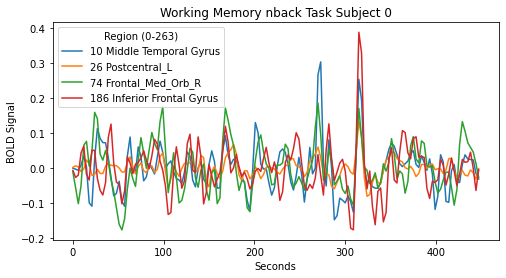

In [25]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(8,4))

ax.plot(np.arange(150)*3, nback[0,[10,26,74,186],:150].T, 
        label=('10 Middle Temporal Gyrus', '26 Postcentral_L', '74 Frontal_Med_Orb_R', '186 Inferior Frontal Gyrus'))
ax.set_ylabel('BOLD Signal')
ax.set_xlabel('Seconds')
ax.legend(title='Region (0-263)')
ax.set_title('Working Memory nback Task Subject 0')
fig.show()
fig.savefig('../../QualifyingExam/Timeseries.png', format='png', bbox_inches='tight')

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:25: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


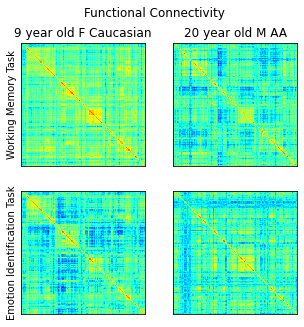

In [88]:
fig, ax = plt.subplots(2,2,figsize=(5,5))

ax[0,0].imshow(nback_p[0], cmap='jet')
ax[0,0].get_xaxis().set_ticks([])
ax[0,0].get_yaxis().set_ticks([])
ax[0,0].set_ylabel('Working Memory Task')
ax[0,0].set_title('9 year old F Caucasian')

ax[1,0].imshow(emoid_p[0], cmap='jet')
ax[1,0].get_xaxis().set_ticks([])
ax[1,0].get_yaxis().set_ticks([])
ax[1,0].set_ylabel('Emotion Identification Task')

ax[0,1].imshow(nback_p[3], cmap='jet')
ax[0,1].get_xaxis().set_ticks([])
ax[0,1].get_yaxis().set_ticks([])
ax[0,1].set_title('20 year old M AA')

ax[1,1].imshow(emoid_p[3], cmap='jet')
ax[1,1].get_xaxis().set_ticks([])
ax[1,1].get_yaxis().set_ticks([])

fig.suptitle('Functional Connectivity')

fig.show()
fig.savefig('../../QualifyingExam/FC.png', format='png', bbox_inches='tight')

In [85]:
[(meta[key]['AgeInMonths'], meta[key]['Gender']) for key in keys]
meta[keys[3]]

{'wratRaw': 57,
 'wratStd': 93,
 'AgeInMonths': 242,
 'Gender': 'M',
 'Ethnicity': 'AFRICAN',
 'rest': array([[ 0.01731686,  0.06640953,  0.06591273, ..., -0.04852552,
         -0.02968997,  0.07815361],
        [ 0.01514655,  0.05584884,  0.04936924, ..., -0.02601919,
         -0.03119869,  0.03883434],
        [-0.00744553, -0.01579226,  0.01826097, ...,  0.01556847,
         -0.06302092, -0.04544802],
        ...,
        [ 0.00611752,  0.0233325 ,  0.01884024, ..., -0.0298549 ,
         -0.2544917 , -0.12963462],
        [ 0.0017482 ,  0.01056522,  0.01291073, ...,  0.09348091,
          0.0462229 , -0.00351819],
        [ 0.00695252,  0.02567983,  0.01716325, ..., -0.09806108,
         -0.04174045, -0.03043296]], dtype=float32),
 'nback': array([[-0.00815128, -0.026762  , -0.0021335 , ...,  0.04296572,
         -0.05862115, -0.09795196],
        [-0.00439075, -0.01401527, -0.00168956, ...,  0.05388665,
         -0.05359273, -0.10752301],
        [ 0.00646102,  0.02688298,  0.03556

/home/anton/.conda/envs/torch/lib/python3.7/site-packages/ipykernel_launcher.py:36: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


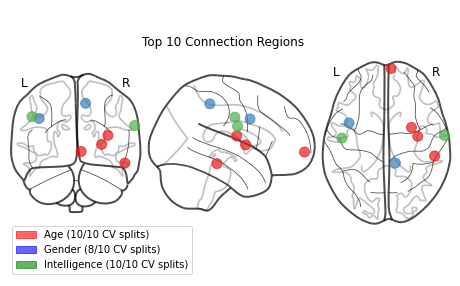

In [2]:
import matplotlib.pyplot as plt
import nilearn.plotting as niplt
import matplotlib.patches as mpatches
import numpy as np

r42 = (36,-9,14)
r230 = (29,1,4)
r10 = (55,-31,-17)
r74 = (6,67,-4)
r186 = (-41,6,33)
r202 = (11,-39,50)
r41 = (-49,-11,35)
r45 = (66,-8,25)

A = np.zeros((8,8))
A[0,1] = 1
A[2,3] = 1
A[4,5] = 1
A[6,7] = 1

A = A+A.T

red_patch = mpatches.Patch(color='red', alpha=0.6, label='Age (10/10 CV splits)')
blue_patch = mpatches.Patch(color='blue', alpha=0.6, label='Gender (8/10 CV splits)')
green_patch = mpatches.Patch(color='green', alpha=0.6, label='Intelligence (10/10 CV splits)')

fig, ax = plt.subplots(1,2,figsize=(16,5))
# niplt.plot_connectome(A, [r42,r230,r10,r74,r186,r202,r41,r45], 
#                       node_color=4*['red']+2*['green']+2*['blue'],
#                        axes=ax, colorbar=False, edge_kwargs={'linewidth':2})
niplt.plot_markers([1,1,1,1,2,2,3,3], [r42,r230,r10,r74,r186,r202,r41,r45], 
                      node_vmin=1, node_vmax=9, node_cmap='Set1',
                       axes=ax[0], colorbar=False)
ax[0].set_title('Top 10 Connection Regions',y=0.8)
ax[0].legend(handles=[red_patch, blue_patch, green_patch], loc='lower left')
fig.show()
# fig.savefig('../../Work/LatentSim/Top10Glass.png', format='png', bbox_inches='tight')

In [92]:
t = 300
9/5*(40000*t+200*t**2+t**3/3+
     40000*np.sin(t)+400*(np.cos(t)+t*np.sin(t))+2*t*np.cos(t)+(t**2-2)*np.sin(t)+5/9*200000-400)/(200+t)**2

279.7974147890032

In [123]:
a = 100*np.log(3)/14-8

In [126]:
b = np.log(3)/14
c = a/b
print(c)
print(8/b)
print(np.log(-8/c/b)/b)

-1.9467933822057806
101.94679338220578
50.44158415845388


In [129]:
-np.log(98/108)

0.09716374845364774